Descrivere con proprie parole (not CHAT-GPT oriented) il concetto di time series forecasting e cosa lo differenzia dai problemi ri regressione standard, fornendo esempi ed applicazioni/limiti.

Le time series sono un algoritmo previsionale di machine learning in modalità supervised. Diamo in pasto un dataset di training di dati reali contenenti due grandezze: il tempo, con relativa granularità temporale, insieme al dato da predire (dato passato antecedente a oggi quindi reale). La predizione del dato viene fatta considerando un determinato intervallo di tempo futuro (mesi, trimestri, semestri, raramente anni) e analizzando fenomeni tipici delle time series: seasonality, ciclicity, trend. Di queste caratteristiche si può appunto provare a predire il loro andamento essendo ricorrenti e cicliche, tramite l'utilizzo di modelli additivi e moltiplicativi che tendono a replicare l'andamento ottenuto nel set di training. Alcune accortezze da fare: 
- assicurarsi che il dataset di test sia il più possibile vicino al presente. Bada bene, non esiste applicare una cross validation qui, vogliamo sempre i dati più vicini al presente;
- più ci si spinge in là nel tempo con le predizioni più aumenta l'errore. Per questo si effettuano previsioni sul breve medio periodo;
- la grandezza da predire deve essere autocorrelata, ovvero deve esistere una correlazione temporale con se stessa (la grandezza al giorno x deve essere in qualche modo correlata al suo valore nel giorno x-1)

In [39]:
#!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/Fake.csv
#!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/True.csv
path_fake = 'https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/Fake.csv'
path_true = 'https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/True.csv'

In [40]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### Read database from path

In [ ]:
#df_fake = pd.read_csv(path_fake)
#df_true = pd.read_csv(path_true)

In [44]:
df_fake["class"] = 0 #fake
df_true["class"] = 1 #real

df_marge = pd.concat([df_fake, df_true], axis =0 )
df = df_marge.drop(["title", "subject","date"], axis = 1)
df = df.sample(frac = 1).reset_index(drop=True)
df

,text,class
0,"Caller-Times: Speaking on CNN Wednesday, the f...",0
1,MADRID (Reuters) - A Spanish audit office has ...,1
2,"New York City begs to differ Of course, this i...",0
3,WASHINGTON (Reuters) - It is a political pract...,1
4,Gayle King was the first to ask Sanders if it ...,0
...,...,...
44893,"RABWAH, Pakistan (Reuters) - Crammed into buse...",1
44894,MOSCOW (Reuters) - The decision to scale back ...,1
44895,MANILA (Reuters) - Philippine President Rodrig...,1
44896,"Clifton Park, New York is the latest school to...",0


In [45]:
dict = {
    1 : "Real",
    0 : "Fake"
}
df["class"] = df["class"].map(dict)

In [46]:
df

,text,class
0,"Caller-Times: Speaking on CNN Wednesday, the f...",Fake
1,MADRID (Reuters) - A Spanish audit office has ...,Real
2,"New York City begs to differ Of course, this i...",Fake
3,WASHINGTON (Reuters) - It is a political pract...,Real
4,Gayle King was the first to ask Sanders if it ...,Fake
...,...,...
44893,"RABWAH, Pakistan (Reuters) - Crammed into buse...",Real
44894,MOSCOW (Reuters) - The decision to scale back ...,Real
44895,MANILA (Reuters) - Philippine President Rodrig...,Real
44896,"Clifton Park, New York is the latest school to...",Fake


In [47]:
# Defining function for applying REGEX patterns
def clean_column(df, column, patterns):
    for pattern, replacement in patterns.items():
        df[column] = df[column].str.replace(pattern, replacement)
        df[column] = df[column].str.lower() # applica il lower
    return df

In [48]:
#controllo a monte
df['text'][5]

'JOHANNESBURG (Reuters) - A violent feud between South African meter taxi drivers and ride-hailing services Uber and Taxify escalated with another three vehicles torched using petrol bombs, police said on Thursday. Drivers for Uber [UBER.UL] and Estonian start-up Taxify operating in Johannesburg and capital Pretoria have faced threats and protests from regular taxi operators who accuse the app-based drivers of poaching customers with cheaper fares. One Uber vehicle and two other taxis were torched last week in the upmarket Sandton district and on Wednesday three Taxify vehicles were set alight in the Pretoria suburb of Sunnyside. Police said in one incident on Wednesday a Taxify driver responding to a pick-up request was cornered by a group of eight men who threatened him with violence just as he arrived at the location.  The vehicle was alight after he had alighted from it. Another Taxify vehicle was set on fire at a different location. One of the vehicles was burned out completely, w

In [49]:
patterns = {
            r'\d+': ' ',          # remove digits (numeri)
            r'[\\]+[n]': '',      # questo rimuove \\n
            r'[^\w\s]': ' ',     # remove punteggiatura e simboli ...,'@!£$%
            r'\b\w{1,2}\b':'',      # remove all token less than2 characters
            r'(http|www)[^\s]+':'', # remove website
            r'\s+': ' ',            # sostituisce tutti i multipli spazi con uno spazio
            }


#just in preview
clean_column(df, 'text', patterns)

,text,class
0,caller times speaking cnn wednesday the fourth...,Fake
1,madrid reuters spanish audit office has demand...,Real
2,new york city begs differ course this just ano...,Fake
3,washington reuters political practice nearly o...,Real
4,gayle king was the first ask sanders was good ...,Fake
...,...,...
44893,rabwah pakistan reuters crammed into buses and...,Real
44894,moscow reuters the decision scale back british...,Real
44895,manila reuters philippine president rodrigo du...,Real
44896,clifton park new york the latest school succum...,Fake


In [50]:
#controllo a valle
df['text'][5]

'johannesburg reuters violent feud between south african meter taxi drivers and ride hailing services uber and taxify escalated with another three vehicles torched using petrol bombs police said thursday drivers for uber uber and estonian start taxify operating johannesburg and capital pretoria have faced threats and protests from regular taxi operators who accuse the app based drivers poaching customers with cheaper fares one uber vehicle and two other taxis were torched last week the upmarket sandton district and wednesday three taxify vehicles were set alight the pretoria suburb sunnyside police said one incident wednesday taxify driver responding pick request was cornered group eight men who threatened him with violence just arrived the location the vehicle was alight after had alighted from another taxify vehicle was set fire different location one the vehicles was burned out completely while the second had slight damages said police captain daniel mavimbela mavimbela said the ide

### EDA using WordCloud

In [53]:
# Creo un'unica stringa da tutti gli elementi di testo
df_filtered_pos = df["text"][df["class"]== "Real"]
df_filtered_neg = df["text"][df["class"]== "Fake"]
text_pos = list(map(str, df_filtered_pos))
text_pos = ''.join(text_pos)
text_neg = list(map(str, df_filtered_neg))
text_neg = ''.join(text_neg)

### Wordcloud Negative

(-0.5, 799.5, 399.5, -0.5)

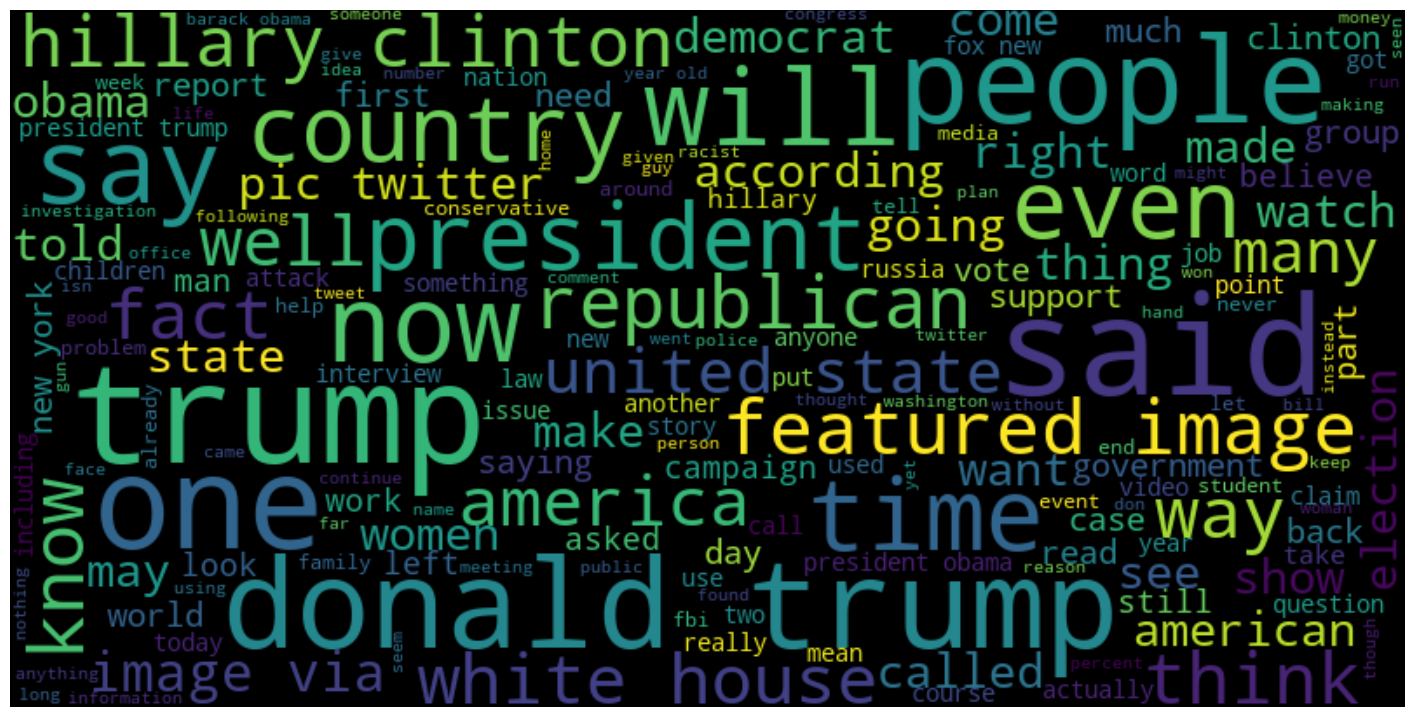

In [54]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      stopwords = STOPWORDS, random_state = 667)

wordcloud.generate(text_neg)
#Grafico
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

### Wordcloud Positive

(-0.5, 799.5, 399.5, -0.5)

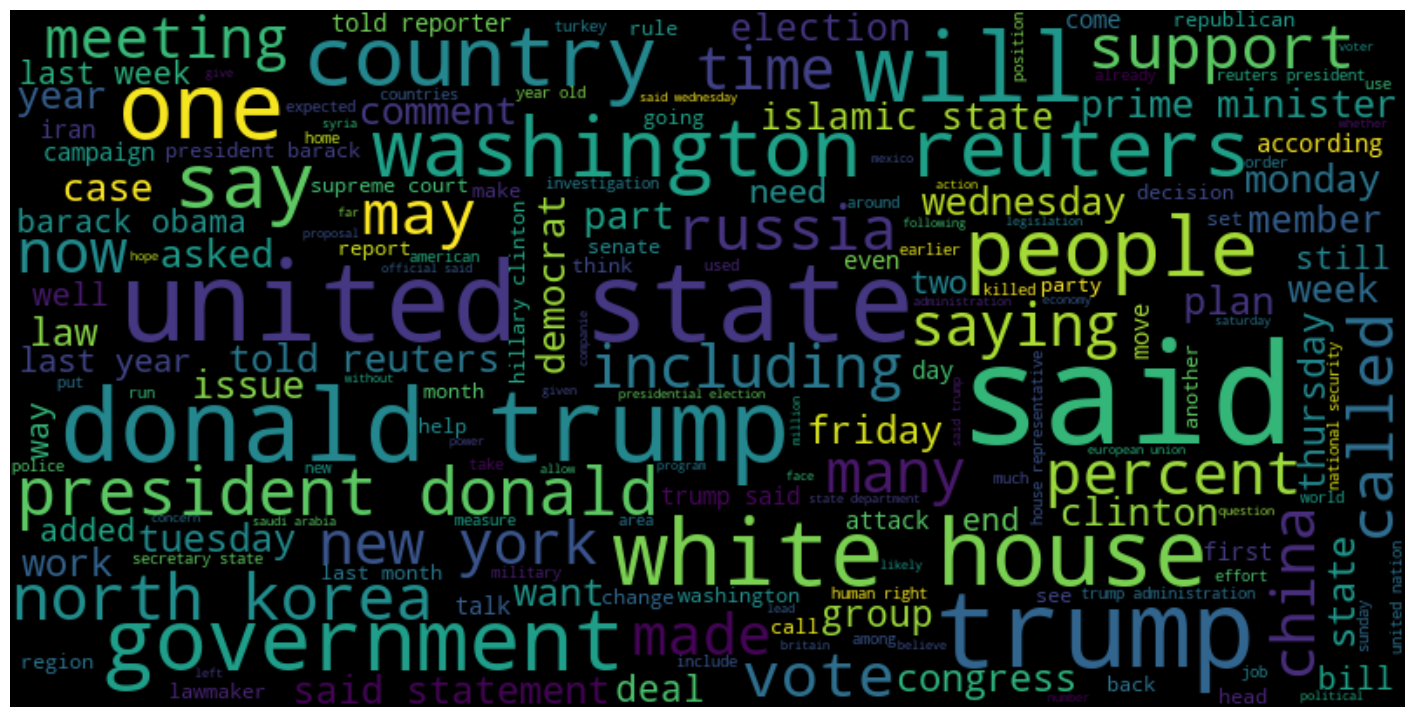

In [55]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      stopwords = STOPWORDS, random_state = 667)

wordcloud.generate(text_pos)
#Grafico
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

In [56]:
# Defining X and y
X = df['text']
y = df['class']

In [57]:
# Vectorization
from sklearn.feature_extraction.text import CountVectorizer

# if number of features exceed maximum memory
vectorizer = CountVectorizer(max_features=3000, min_df=5, max_df=0.7)
#vectorizer = CountVectorizer(stop_words='english')
X_vect = vectorizer.fit_transform(X).toarray()
X_vect

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 4, ..., 0, 0, 0]], dtype=int64)

In [58]:
X_vect.shape

(44898, 3000)

In [59]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_tfidf = tfidfconverter.fit_transform(X_vect).toarray()
X_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.11550294, ..., 0.        , 0.        ,
        0.        ]])

In [60]:
X_tfidf.shape

(44898, 3000)

In [61]:
# Split Training and Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y,
                                                    test_size=0.3, 
                                                    random_state=667
                                                    )

In [62]:
# Data Modeling
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=667,max_depth=5)
classifier.fit(X_train, y_train) 

# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_pred, y_test)
test_data_accuracy

0.96362286562732

In [63]:
labels = ['Fake', 'Real']

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

        Fake       0.99      0.94      0.96      7025
        Real       0.94      0.99      0.96      6445

    accuracy                           0.96     13470
   macro avg       0.96      0.96      0.96     13470
weighted avg       0.96      0.96      0.96     13470



Text(95.72222222222221, 0.5, 'Actual')

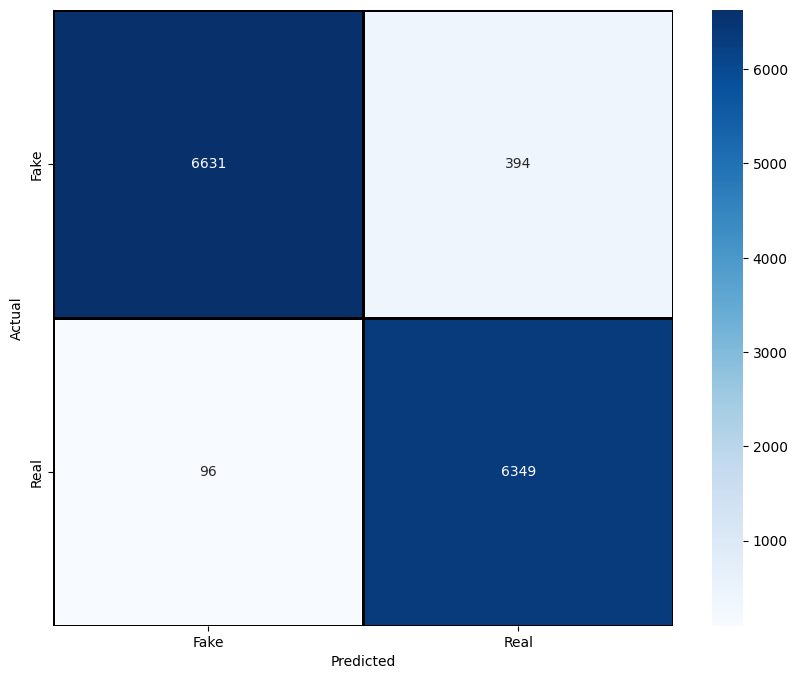

In [64]:
labels = ['Fake', 'Real']

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [65]:
# accuracy score on the test data
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=667, max_iter=5, tol=None)
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
test_data_accuracy

0.9547141796585004

In [66]:
# Step 8: Pipeline Finale (nuovo train test split su dati raw tetuali)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=667
                                                    )


In [67]:
from sklearn.pipeline import Pipeline

bow = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
tfidf = TfidfTransformer()
clf =SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=667, max_iter=5, tol=None)
#clf = classifier = MultinomialNB()

pipe = Pipeline([
                ('bow',bow),
                ('tfidf',tfidf),
                ('clf',clf),
                ])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9765404602821084


In [68]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

        Fake       0.98      0.97      0.98      7025
        Real       0.97      0.98      0.98      6445

    accuracy                           0.98     13470
   macro avg       0.98      0.98      0.98     13470
weighted avg       0.98      0.98      0.98     13470



Text(95.72222222222221, 0.5, 'Actual')

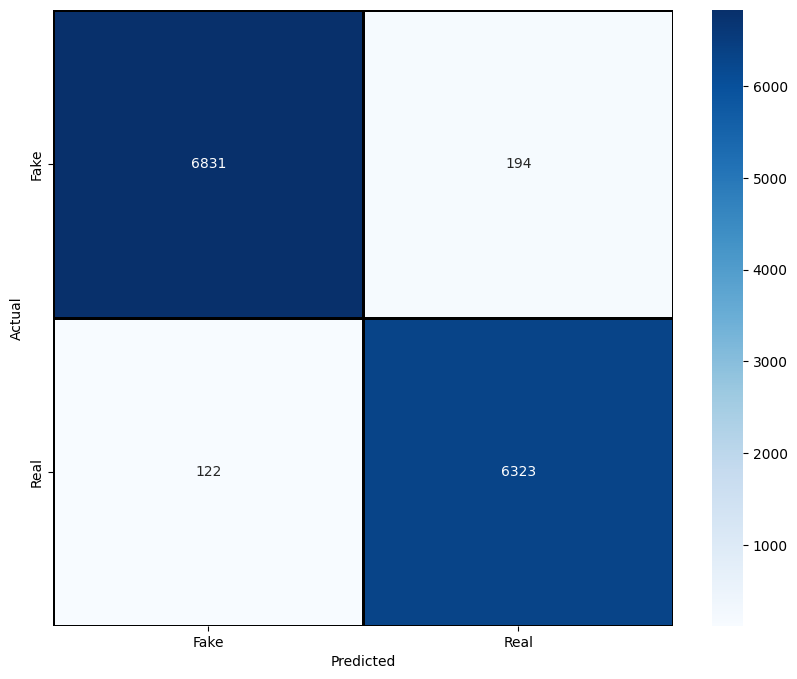

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [70]:
# Step 10: Cross Validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, X, y, scoring = 'f1_micro', cv = 8)

print(f'scores={scores}')
print(f'mean={np.mean(scores)}')
print(f'std={np.std(scores)}')

scores=[0.97309816 0.97541422 0.97202423 0.97487527 0.97416251 0.97344975
 0.9743407  0.97790449]
mean=0.9744086664205727
std=0.0016521690037775735


In [71]:
import joblib
joblib.dump(pipe,'NLP-model.pkl')

['NLP-model.pkl']

In [72]:
import joblib

uploaded_model = joblib.load('NLP-model.pkl')
pred = uploaded_model.predict(['hello'])
pred[0]

'Fake'

streamlit https://frank-leogit-esame-data-mining-app-3fcycx.streamlit.app/


repo https://github.com/Frank-Leogit/Esame_Data_Mining